# Notebook to match VASCA sources to SIMBAD database sources positionally
Set your option in the cell bellow

In [1]:
from astropy import units as uu
region_name = "ALL_10-800" #"CAINGSGII_10-800" #"TDS" #"CAINGSGII_10-800" #"WD" #"MDIS_10-800" #"TDS" #  _ELAISN1
region_cat_fname = "./vasca_pipeline/"+region_name+"/region_"+region_name+"_cat.fits"

In [2]:
%matplotlib widget
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
from vasca.region import Region
import vasca.visualization as vvis
from vasca.utils import otype2ogroup,dd_ogrp2otypes, dd_ogrp2col, get_col_cycler,add_ogrp

# Get region
rc = Region()
rc.load_from_fits(region_cat_fname)

### Prepare association data for plotting

In [3]:
#Add Object group to source table
# rc.add_column("tt_sources", "otype")
# rc.tt_sources.add_index("rg_src_id")
# src_idx = rc.tt_sources.loc_indices[rc.tt_simbad["rg_src_id"]]
# rc.tt_sources["otype"][src_idx]=rc.tt_simbad["otype"]

rc.copy_table_columns("tt_sources","tt_simbad",["otype","match_distance"],"rg_src_id")
rc.tt_sources.rename_column("match_distance","match_distance_simbad")
sel_simbad = rc.tt_sources["sel"].data
print(f"Number of SIMBAD matches is: {sel_simbad.sum()}  ({100* sel_simbad.sum() / len(rc.tt_sources)} )%")

rc.copy_table_columns("tt_sources","tt_gaiadr3",["PQSO", "PGal", "PSS","match_distance"],"rg_src_id")
rc.tt_sources.rename_column("match_distance","match_distance_gaiadr3")
sel_gaiadr3 = rc.tt_sources["sel"].data
print(f"Number of GAIA matches is: {sel_gaiadr3.sum()}  ({100*sel_gaiadr3.sum() / len(rc.tt_sources)} )%")

add_ogrp(rc,"tt_sources")
add_ogrp(rc,"tt_otypes")

display(rc.tt_sources)
#display(rc.tt_simbad)


Number of SIMBAD matches is: 85  (1.1943234508922298 )%
Number of GAIA matches is: 76  (1.067865673738935 )%


fd_src_id,nr_det,ra,dec,pos_err,pos_xv,pos_var,pos_cpval,pos_rchiq,coadd_src_id,coadd_dist,obs_filter_id,sel,flux,flux_err,flux_nxv,flux_var,flux_cpval,flux_rchiq,coadd_ffactor,coadd_fdiff_s2n,rg_fd_id,rg_src_id,nr_fd_srcs,hr,hr_err,simbad_match_id,gaiadr3_match_id,otype,match_distance_simbad,PQSO,PGal,PSS,match_distance_gaiadr3,ogrp
,,deg,deg,arcsec,arcsec2,arcsec2,,,,arcsec,,,1e-06 Jy,1e-06 Jy,,1e-12 Jy2,,,,,,,,,,,,,arcsec,,,,arcsec,
int32,int32[2],float64,float64,float32,float32,float32,float32,float32,int64,float32,int32[2],bool,float32[2],float32[2],float32[2],float32[2],float32[2],float32[2],float32[2],float32[2],int64,int32,int32,float32,float32,int32,int32,bytes32,float32,float32,float32,float32,float32,bytes8
-1,175 .. 98,150.19491746654782,2.067917488917891,0.041145824,-0.33278635,0.15272313,1.0,0.30049813,867,0.063385345,1 .. 2,True,14.334563 .. 8.805813,0.07181169 .. 0.109138064,0.010237182 .. 0.009757584,3.5745542 .. 2.283225,0.0 .. 3.814655e-12,3.7095704 .. 2.3172796,0.97875947 .. 1.0259458,-3.2490458 .. 1.6797316,-1,26,10,0.6041421,0.008988117,0,0,Sy1,0.7002527,0.001869,0.000724,0.996765,0.7002527,AGN
-1,148 .. 130,150.1799556325474,2.1103312162731735,0.041883517,-0.28210574,0.24747498,1.0,0.4775786,67,0.04405546,1 .. 2,True,17.591288 .. 6.566322,0.091125205 .. 0.082030274,0.002693037 .. 0.0027621754,2.8632436 .. 1.2160017,1.9439212e-11 .. 0.48239988,1.9737328 .. 1.0003253,0.98499906 .. 1.0091033,-2.4839041 .. 0.59337366,-1,31,10,0.36145002,0.0069398326,1,1,QSO,0.91459554,0.000287,0.00016,0.998952,0.91459554,AGN
-1,187 .. 68,150.14575415476628,2.043070325208979,0.045412708,-0.37028584,0.20188043,1.0,0.359057,906,0.05303263,1 .. 2,True,10.106851 .. 3.813408,0.06261327 .. 0.08893104,0.026032418 .. 0.0071979486,3.7612705 .. 0.6972077,0.0 .. 0.06236148,5.602206 .. 1.2777138,0.9619016 .. 1.0913291,-4.680506 .. 3.0474873,-1,47,10,0.35370108,0.010773277,3,2,QSO,0.597173,0.001265,1.3e-05,0.997987,0.597173,AGN
-1,223 .. 56,150.10187076794713,2.105622112305161,0.043903112,-0.14818236,0.44276938,0.9999879,0.6311722,167,0.39357263,1 .. 2,True,9.242619 .. 3.2214422,0.05453549 .. 0.08941889,0.0057370258 .. -0.007204072,1.4249276 .. 0.44153178,2.5193283e-11 .. 0.9649644,1.7552807 .. 0.68344927,0.9801208 .. 1.0516087,-2.546556 .. 1.5815244,-1,65,10,0.35043922,0.011155928,4,3,QSO,0.7378542,1.0,0.0,0.0,0.7378542,AGN
-1,17 .. 19,150.25768134959162,2.429976464041846,0.1531103,-0.251353,0.67691404,0.00042565385,1.2249864,801,0.44043687,1 .. 2,False,3.6412191 .. 3.0093424,0.15282841 .. 0.1460866,2.0983272 .. -0.03354601,28.29587 .. 0.13118833,0.0 .. 0.9986987,18.125904 .. 0.28323573,1.0971218 .. 1.3153098,2.012671 .. 4.707052,-1,134,9,1.2379429,0.33605915,5,-1,G,0.66343427,-1.0,-1.0,-1.0,-1.0,GAL
-1,162 .. 63,215.0652986717028,52.62191634479354,0.04258191,-0.15678811,0.2601927,0.97151285,0.61557895,493,0.108201735,1 .. 2,True,23.9785 .. 10.414039,0.0822385 .. 0.13372463,0.017198535 .. 0.0045054667,11.087525 .. 1.7450621,0.0 .. 0.0063142804,9.222982 .. 1.5036017,0.98297095 .. 0.9983051,-4.0039735 .. -0.113926,-1,177,8,0.4045591,0.0070522213,6,4,QSO,0.244159,1.0,0.0,0.0,0.24415898,AGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-1,6 .. -1,6.013936547211533,-72.22173607880508,0.32587492,-0.31301472,0.3354815,0.3951696,0.56316364,3424414,0.13161364,1 .. 0,False,4.7824826 .. -1.0,0.34806773 .. -1.0,-0.020964481 .. -100.0,0.3542065 .. -1.0,0.77017957 .. -1.0,0.50837004 .. -1.0,2.3786764 .. 1.0,7.450393 .. 0.0,-1,983122,1,-1.0,-1.0,-1,-1,none,-1.0,-1.0,-1.0,-1.0,-1.0,UNK


### Create matching table

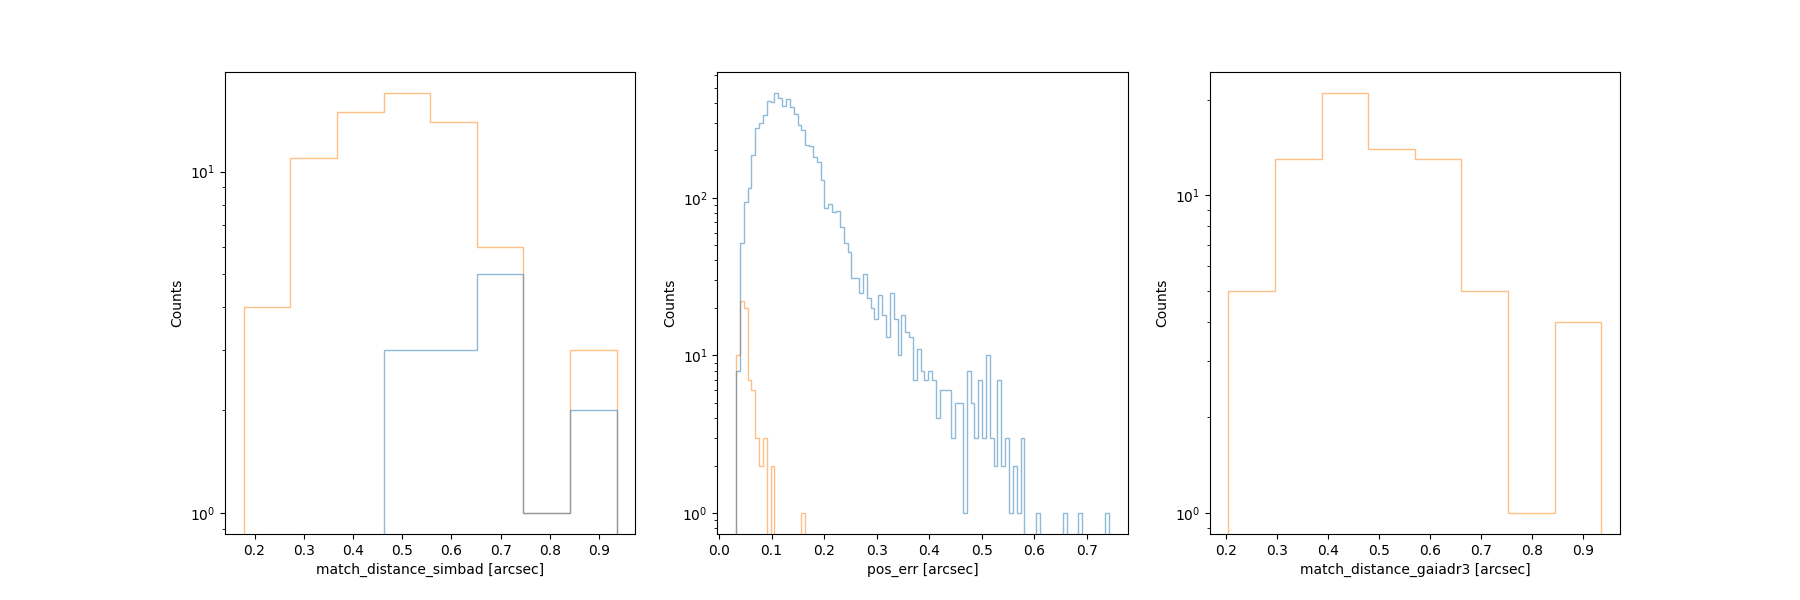

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs = np.array(axs).flatten()
_ = vvis.plot_table_hist(rc.tt_sources[sel_simbad], "match_distance_simbad", ax=axs[0], logx=False, obs_filter_id=None, density= False)
_ = vvis.plot_table_hist(rc.tt_sources, 'pos_err', ax=axs[1], logx=False, obs_filter_id=None, density= False)
_ = vvis.plot_table_hist(rc.tt_sources[sel_gaiadr3], "match_distance_gaiadr3", ax=axs[2], logx=False, obs_filter_id=None, density= False)

### Plot found object types

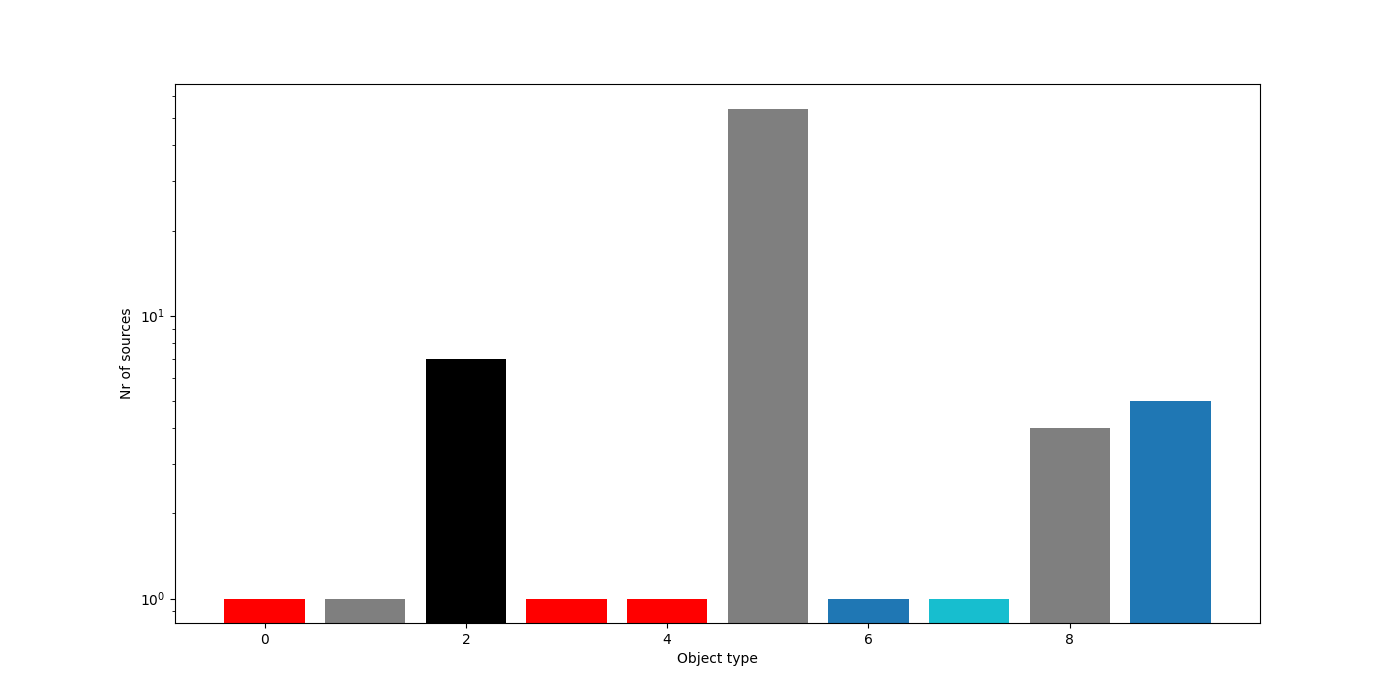

otype Candidate      Description       ogrp   Label               Category                                    Subcategory                         
                                                                                                                                                  
----- --------- ---------------------- ---- ---------- ------------------------------ ------------------------------------------------------------
    *        --                   Star Star       Star           1. TAXONOMY OF STARS                                                           --
  AGN       AG?  Active Galaxy Nucleus  AGN        AGN        4. TAXONOMY OF GALAXIES                                                           --
    G        G?                 Galaxy  GAL     Galaxy        4. TAXONOMY OF GALAXIES                                                           --
  GrG       Gr?      Group of Galaxies  GAL     GroupG            5. SETS OF GALAXIES                                 

In [5]:
sel_mt = rc.tt_sources["sel"]
fig_otypes = plt.figure("Source types",figsize=(14, 7))
fig_otypes.clf()

otypes_all, otype_cts_all= np.unique(rc.tt_sources[sel_mt]["otype"],return_counts=True)
dd_otype2id = dict(zip(list(otypes_all),range(len(otypes_all))))

tt_mt_grp =  rc.tt_sources[sel_mt].group_by("ogrp")
for group, tt_grp in zip(tt_mt_grp.groups.keys, tt_mt_grp.groups):
    otypes, otype_cts= np.unique(tt_grp["otype"],return_counts=True)
    otypes_id = []
    for otype in otypes:
        otypes_id.append(dd_otype2id[otype])
    plt.bar( otypes_id, otype_cts, align='center', label=group[0], color = dd_ogrp2col[group[0]])
plt.yscale('log')
#plt.grid()
plt.xlabel("Object type")
plt.ylabel("Nr of sources")
plt.show()
plt.legend()
plt.xticks(range(len(otypes_all)), otypes_all, size='small')

rc.tt_otypes["otype","Candidate","Description","ogrp","Label","Category","Subcategory"].pprint_all()#show_dtype=True #,"Status","Priority"


### Scatter plots of source variables by group

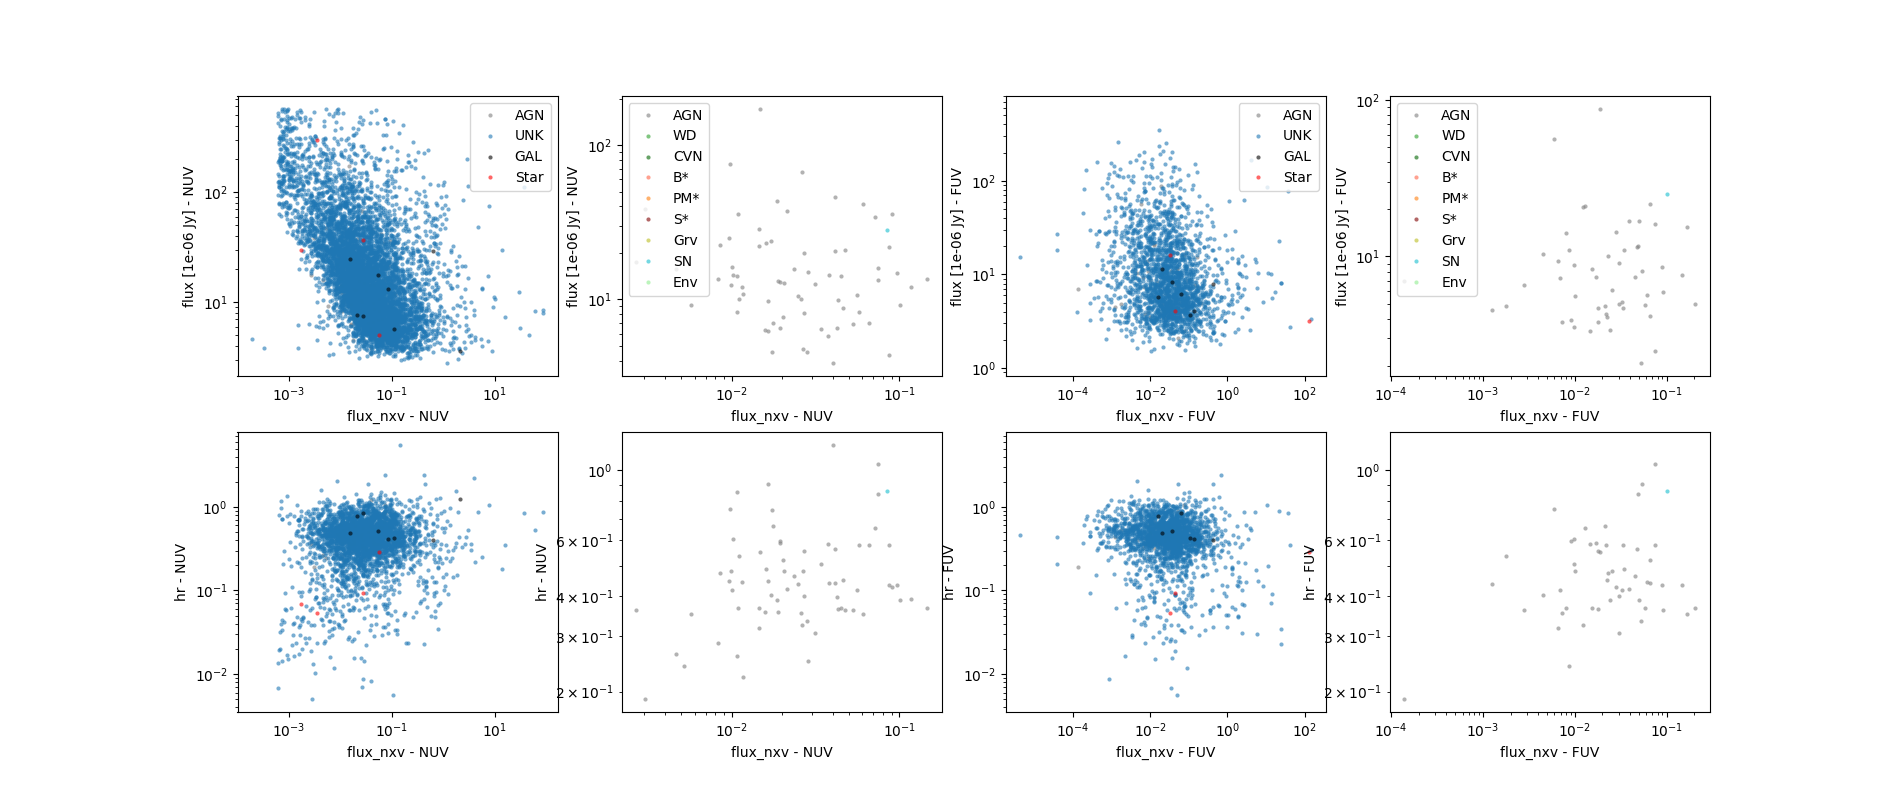

In [6]:
plot_kwargs = {"markersize": 3.0,"alpha":0.6}
fig, axs = plt.subplots(2, 4, figsize=(19, 8))
#fig.clf()
axs = axs.flatten()
plt_ogrops = [["AGN","UNK","GAL",'Star'],["AGN",'WD', 'CVN', 'B*', 'PM*',"S*", 'Grv', 'SN',"Env"]]

plt_flts = [1,2]
ctr = 0
for flt in plt_flts:
    for ogrps in plt_ogrops:
        #axs[ctr].cla()
        axs[ctr].set_prop_cycle(get_col_cycler(ogrps))
        vvis.plot_table_scatter(rc.tt_sources,"flux_nxv", "flux", ax=axs[ctr], xscale="log",yscale="log", obs_filter_id=flt, grp_var="ogrp",grp_vals = ogrps,**plot_kwargs)

        #axs[ctr+4].cla()
        axs[ctr+4].set_prop_cycle(get_col_cycler(ogrps))
        vvis.plot_table_scatter(rc.tt_sources,"flux_nxv", "hr", ax=axs[ctr+4], xscale="log",yscale="log", obs_filter_id=flt, grp_var="ogrp",grp_vals = ogrps,**plot_kwargs)
        ctr +=1

_ = axs[0].legend()
_ = axs[1].legend()
_ = axs[2].legend()
_ = axs[3].legend()
#print(dd_ogrp2otypes.keys())r

### Print info for selected sources

In [7]:
# Make selection
sel_otype = rc.tt_sources["otype"] ==  "RR*"# "No*"#"HS?" #"BS*" #"PM*" # # "SN*" #"EB*"
sel_otypes = (rc.tt_sources["otype"] ==  "WD?")  + (rc.tt_sources["otype"] =="WD*")
sel_flux_nxv = rc.tt_sources["flux_nxv"][:,0]>2
sel_flux_hr = rc.tt_sources["hr"]>2
sel_src_id = rc.tt_sources["rg_src_id"]==15179
sel_srcs =  sel_otypes  #sel_src_id  #sel_flux_nxv #sel_otype # sel_flux_nxv_fuv # sel_flux_hr#

#Display match and simbad table for selected sources
display(rc.tt_sources[sel_srcs])

#Print oout list of source IDs to be used for further use, e.g. in inspect_sources.ipynb
print("srcs_ids = [", end="")
for src_id in rc.tt_sources[sel_srcs]["rg_src_id"].data:
    print(src_id,",", end="")
print("]")

fd_src_id,nr_det,ra,dec,pos_err,pos_xv,pos_var,pos_cpval,pos_rchiq,coadd_src_id,coadd_dist,obs_filter_id,sel,flux,flux_err,flux_nxv,flux_var,flux_cpval,flux_rchiq,coadd_ffactor,coadd_fdiff_s2n,rg_fd_id,rg_src_id,nr_fd_srcs,hr,hr_err,simbad_match_id,gaiadr3_match_id,otype,match_distance_simbad,PQSO,PGal,PSS,match_distance_gaiadr3,ogrp
,,deg,deg,arcsec,arcsec2,arcsec2,,,,arcsec,,,1e-06 Jy,1e-06 Jy,,1e-12 Jy2,,,,,,,,,,,,,arcsec,,,,arcsec,
int32,int32[2],float64,float64,float32,float32,float32,float32,float32,int64,float32,int32[2],bool,float32[2],float32[2],float32[2],float32[2],float32[2],float32[2],float32[2],float32[2],int64,int32,int32,float32,float32,int32,int32,bytes32,float32,float32,float32,float32,float32,bytes8


srcs_ids = []


Identified sources:
1) 150.38873296492392	1.7245661255048343; GNU2605264352416104448 PS_COSMOS_MOS26; LINEAR 21145823;RR*;Very large flux_nxv_fuv=47 and very low hr 0.026; 

In [8]:
from astroquery.simbad import Simbad

testSimbad = Simbad()

#testSimbad.list_votable_fields()
all_vo_fields = ["biblio","cel","cl.g","coo(opt)","coo_bibcode","coo_err_angle","coo_err_maja","coo_err_mina","coo_qual","coo_wavelength","coordinates","dec(opt)","dec_prec","diameter","dim","dim_angle","dim_bibcode","dim_incl","dim_majaxis","dim_minaxis","dim_qual","dim_wavelength","dimensions","distance","distance_result","einstein","fe_h","flux(filtername)","flux_bibcode(filtername)","flux_error(filtername)","flux_name(filtername)","flux_qual(filtername)","flux_system(filtername)","flux_unit(filtername)","fluxdata(filtername)","gcrv","gen","gj","hbet","hbet1","hgam","id(opt)","ids","iras","irc","iso","iue","jp11","link_bibcode","main_id","measurements","membership","mesplx","mespm","mk","morphtype","mt","mt_bibcode","mt_qual","otype","otype(opt)","otypes","parallax","plx","plx_bibcode","plx_error","plx_prec","plx_qual","pm","pm_bibcode","pm_err_angle","pm_err_maja","pm_err_mina","pm_qual","pmdec","pmdec_prec","pmra","pmra_prec","pos","posa","propermotions","ra(opt)","ra_prec","rot","rv_value","rvz_bibcode","rvz_error","rvz_qual","rvz_radvel","rvz_type","rvz_wavelength","sao","sp","sp_bibcode","sp_nature","sp_qual","sptype","td1","typed_id","ubv","uvby","uvby1","v*","velocity","xmm","z_value"]

#for vo_field in all_vo_fields:
#    print("*",vo_field)
#    testSimbad.get_field_description(vo_field)